First we connect to drive and locate the working directory

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd gdrive/MyDrive/Colab\ Notebooks/ANN_DL2021/Project_1_Leaf_Classification/ANNDL_Challenge/
%ls

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1kFj1EXUioJSt02up8iZJ3g9DL3yaXUAX/ANNDL_Challenge
balanced_dataset/
balanced.zip
Custom_CNN.ipynb
dataset.zip
DRTNet_InceptionNetV3.ipynb
DRTNet_TransferLearning_and_FineTuning.ipynb
DRTNet_Visualizations.ipynb
Histories/
lib/
saved_models/
ToySubmission/
training/
transfer_learning_efficientnet.ipynb


### Load modules

In [2]:
import os
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tqdm.notebook import tqdm
import cv2

# Import library functions
import lib.utils as util
import lib.loaders as loaders
import lib.models as m

print(tf.__version__)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.7.0


### Get data

Unzip dataset if necessary

In [3]:
if not os.path.exists("balanced_dataset"):
  !unzip balanced.zip -d balanced_dataset > /dev/null

Set parameters for data. Load it and visualize

Found 15204 images belonging to 14 classes.
Found 1680 images belonging to 14 classes.


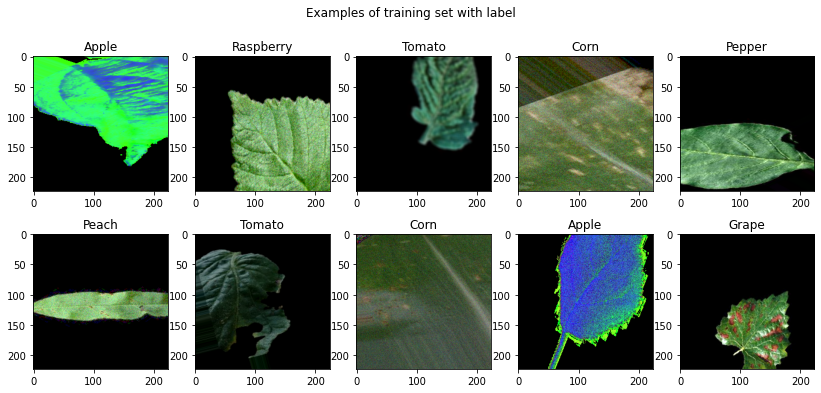

Data range: [ 0.0 , 1.0 ]


In [4]:
# Set directory
training_dir = 'balanced_dataset/balanced/'

# Set dataset parameters
batch_size = 16           # Batch size
IMG_SHAPE = (224,224,3)   # Image shape
validation_split = 0.1    # Split between train and validation
auglevel = 2              # The level of augmentation (0 is no augmentation) possible values: 0,1,2

# Fetch the data loaders
train_loader,val_loader = loaders.get_loaders(batch_size,IMG_SHAPE,validation_split,
                training_dir, auglevel, seed=seed)

# Visualize data
f,ax = util.visualize_data(train_loader)

### Load models

A number of models have been trained and we can then load them and their history

In [5]:
# Define paths
model_path = "saved_models/"

# Define names
model_name1 = "vgg_aug2_ft_ft"
model_name2 = "inception_aug2_ft_ft"

In [6]:
# Load first model
model1 = tf.keras.models.load_model(model_path+model_name1)
full_hist1 = np.load(model_path + model_name1+"_hist.npy",
                          allow_pickle='TRUE').item()

# Load second model
model2 = tf.keras.models.load_model(model_path+model_name2)
full_hist2 = np.load(model_path + model_name2+"_hist.npy",
                          allow_pickle='TRUE').item()

In [19]:
# Get another history
PATH = "Histories/"

# Get CNN history
p1 = "history_CNN/history_CNN/"
files1 = ["history_gap.npy","history_gap2.npy","history_gap3.npy"]

full_hist3 = np.load(PATH + p1+files1[0],allow_pickle='TRUE').item()
for file in files1[1:]:
  temp = np.load(PATH + p1+file,allow_pickle='TRUE').item()
  full_hist3 = util.combine_dicts(full_hist3,temp)

# Get efficientnet history
p2 = "history_efficientnet/history_efficientnet/"
files2 = ["history.npy","history2.npy","history3.npy","history4.npy","history5.npy"]

full_hist4 = np.load(PATH + p2+files2[0],allow_pickle='TRUE').item()
for file in files2[1:]:
  temp = np.load(PATH+p2+file,allow_pickle='TRUE').item()
  full_hist4 = util.combine_dicts(full_hist4,temp)

### Confusion matrix

Compute and visualize the confusion matrix for a model

In [ ]:
# Compute confusion matrices
cm_train = util.compute_confusion_matrix(model2, train_loader)
cm_val = util.compute_confusion_matrix(model2, val_loader)

Running : 100%|██████████| 105/105 [03:34<00:00,  2.05s/it]


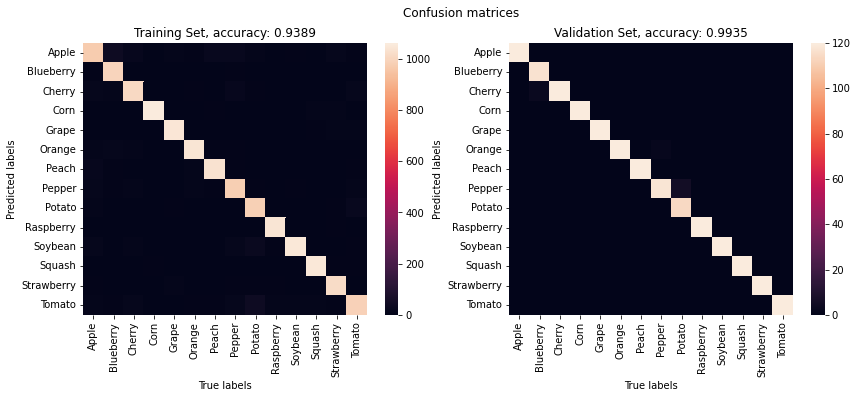

Accuracy Train: 0.9388976585109182
Accuracy Train: 0.993452380952381


In [ ]:
# Plot confusion matrix
f,ax = util.CM_whole_dataset(cm_train,cm_val)
plt.show()
# f.savefig('ConfusionMatrices.png',dpi=300,bbox_inches='tight')

acc_train = np.sum(np.diag(cm_train))/np.sum(cm_train)
acc_val = np.sum(np.diag(cm_val))/np.sum(cm_val)
print("Accuracy Train:",acc_train)
print("Accuracy Train:",acc_val)

### Learning curves

Plot learning curves from models

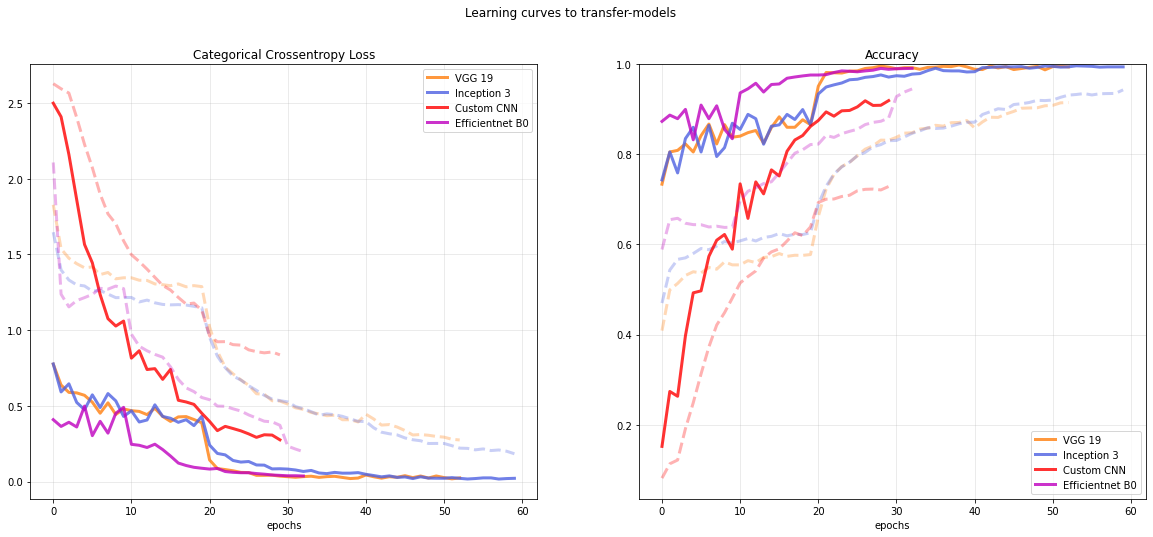

In [26]:

f,ax = plt.subplots(1,2,figsize=(20,8))
ax[0].plot(full_hist1['loss'], alpha=.3, color='#ff7f0e', linestyle='--',linewidth=3)
ax[0].plot(full_hist1['val_loss'], alpha=.8, color='#ff7f0e',linewidth=3, label='VGG 19')
ax[0].plot(full_hist2['loss'], alpha=.3, color='#4D61E2',linewidth=3, linestyle='--')
ax[0].plot(full_hist2['val_loss'], alpha=.8, color='#4D61E2',linewidth=3, label='Inception 3')
ax[0].plot(full_hist3['loss'], alpha=.3, color='r',linewidth=3, linestyle='--')
ax[0].plot(full_hist3['val_loss'], alpha=.8, color='r',linewidth=3, label='Custom CNN')
ax[0].plot(full_hist4['loss'], alpha=.3, color='m',linewidth=3, linestyle='--')
ax[0].plot(full_hist4['val_loss'], alpha=.8, color='m',linewidth=3, label='Efficientnet B0')
ax[0].legend()
ax[0].set_title('Categorical Crossentropy Loss')
ax[0].grid(alpha=.3)
ax[0].set_xlabel('epochs')
ax[1].plot(full_hist1['accuracy'], alpha=.3, color='#ff7f0e',linewidth=3, linestyle='--')
ax[1].plot(full_hist1['val_accuracy'], alpha=.8, color='#ff7f0e',linewidth=3, label='VGG 19')
ax[1].plot(full_hist2['accuracy'], alpha=.3, color='#4D61E2',linewidth=3, linestyle='--')
ax[1].plot(full_hist2['val_accuracy'], alpha=.8, color='#4D61E2',linewidth=3, label='Inception 3')
ax[1].plot(full_hist3['accuracy'], alpha=.3, color='r',linewidth=3, linestyle='--')
ax[1].plot(full_hist3['val_accuracy'], alpha=.8, color='r',linewidth=3, label='Custom CNN')
ax[1].plot(full_hist4['accuracy'], alpha=.3, color='m',linewidth=3, linestyle='--')
ax[1].plot(full_hist4['val_accuracy'], alpha=.8, color='m',linewidth=3, label='Efficientnet B0')
ax[1].legend()
ax[1].set_title('Accuracy')
ax[1].grid(alpha=.3)
ax[1].set_ylim(top=1)
ax[1].set_xlabel('epochs')
f.suptitle('Learning curves to transfer-models')
plt.show()
# f.savefig('transfer_comparison2.png',dpi=300,bbox_inches='tight')
